In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Data Profiling Setup Complete")

Data Profiling Setup Complete


In [53]:
toilet_locations = "../data/ext_data/data/public_restrooms_20251016.csv"
df_toilet_raw = pd.read_csv(toilet_locations)
print(df_toilet_raw.head())
print(len(df_toilet_raw))

            Facility Name Location Type     Operator                   Status  \
0     Battery Park Zone 1          Park    NYC Parks          Not Operational   
1   Carl Schurz Main Lawn          Park    NYC Parks          Not Operational   
2             Tappen Park          Park    NYC Parks          Not Operational   
3       Refinery Building          Park  Domino Park              Operational   
4  Gravesend Library, BPL       Library          BPL  Closed for Construction   

         Open Hours of Operation         Accessibility  \
0         NaN                NaN                   NaN   
1         NaN                NaN  Partially Accessible   
2         NaN                NaN                   NaN   
3  Year Round           6am-11pm                   NaN   
4  Year Round                NaN      Fully Accessible   

                         Restroom Type        Changing Stations  \
0                                  NaN                      Yes   
1            Multi-Stall W/M R

Tidbit:
* 91% operational
* 9% are non-operational or closed for construction


Plan
* Join the public restrooms database with the the park information, and then use the coordinates to do a FIPS association

In [54]:
print(f"Toilet Inventory Columns: {df_toilet_raw.columns}")

park_master_locations = "../data/ext_data/data/parks_properties_20250930.csv"
df_parks = pd.read_csv(park_master_locations)
print(f"Park Metadata Columns: {df_parks.columns}")

Toilet Inventory Columns: Index(['Facility Name', 'Location Type', 'Operator', 'Status', 'Open',
       'Hours of Operation', 'Accessibility', 'Restroom Type',
       'Changing Stations', 'Additional Notes', 'Website', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')
Park Metadata Columns: Index(['ACQUISITIONDATE', 'ACRES', 'ADDRESS', 'BOROUGH', 'CLASS',
       'COMMUNITYBOARD', 'COUNCILDISTRICT', 'DEPARTMENT', 'EAPPLY', 'GISOBJID',
       'GISPROPNUM', 'GlobalID', 'JURISDICTION', 'LOCATION', 'MAPPED',
       'NAME311', 'NYS_ASSEMBLY', 'NYS_SENATE', 'OBJECTID', 'OMPPROPID',
       'PARENTID', 'PERMIT', 'PERMITDISTRICT', 'PERMITPARENT', 'PIP_RATABLE',
       'PRECINCT', 'RETIRED', 'SIGNNAME', 'SUBCATEGORY', 'TYPECATEGORY',
       'US_CONGRESS', 'WATERFRONT', 'ZIPCODE', 'multipolygon'],
      dtype='object')


In [55]:
park_sites_location = "../data/ext_data/data/parks_inspection_program_–_all_sites_mapped_20251018.csv"
park_inspections_location = "../data/ext_data/data/parks_inspection_program_–_inspections_20251018.csv"
park_restroom_inspections_location = "../data/ext_data/data/parks_inspection_program_–_public_restroom_inspections_20251018.csv"
park_restroom_rooms_inspections_location = "../data/ext_data/data/parks_inspection_program_–_public_restroom_individual_room_inspections_20251018.csv"
park_restroom_hazards_location = "../data/ext_data/data/parks_inspection_program_–_public_restroom_conditions_&_hazards_20251018.csv"

park_sites_df = pd.read_csv(park_sites_location)
park_inspections_df = pd.read_csv(park_inspections_location)
park_restroom_inspections_df = pd.read_csv(park_restroom_inspections_location)
park_restroom_rooms_inspections_df = pd.read_csv(park_restroom_rooms_inspections_location)
park_restroom_hazards_df = pd.read_csv(park_restroom_hazards_location)

print(f"Park Sites Columns: {park_sites_df.columns}")
print(f"Inspection Columns: {park_inspections_df.columns}")
print(f"Restroom Inspection Columns: {park_restroom_inspections_df.columns}")
print(f"Restroom Rooms Inspection Columns: {park_restroom_rooms_inspections_df.columns}")
print(f"Restroom Rooms Hazards Columns: {park_restroom_hazards_df.columns}")


Park Sites Columns: Index(['PropNum', 'Prop ID', 'Boro', 'AMPSDistrict', 'Prop Name', 'Site Name',
       'Prop Location', 'Site Location', 'Acres', 'Category', 'Sub-Category',
       'Rated', 'Reason Not Rated', 'Council District', 'ZipCode',
       'COMMUNITYBOARD', 'Jurisdiction', 'NYSAssembly', 'NYSSenate',
       'USCongress', 'Precinct', 'PublicRestroom', 'Multipolygon', 'Sourcefc'],
      dtype='object')
Inspection Columns: Index(['Prop ID', 'AMPSDistrict', 'Inspection ID', 'Season', 'Round', 'Date',
       'BeginInspection', 'EndInspection', 'Inspection Year', 'inspector',
       'inspector2', 'Overall Condition', 'Cleanliness', 'Safety Condition',
       'Structural Condition', 'VisitorCount', 'Closed?', 'Comments',
       'InspectionType', 'inspAddedDate'],
      dtype='object')
Restroom Inspection Columns: Index(['InspectionID', 'PRNumber', 'PR Overall Condition', 'PR Litter',
       'PR Graffiti', 'PR Amenities', 'PR Structural'],
      dtype='object')
Restroom Rooms Inspec

Based on https://docs.google.com/spreadsheets/d/17LSfFUkhHPHJS4hszOYMVmVyU3xVF7J_dILhtIwWKKA/edit?gid=2034137855#gid=2034137855, the join pattern is:
* Each INSPECTION record will have 0..N restroom inspections and 0..N restroom room inspections
* Each INSPECTION record has a Prop ID
* In the INSPECTION record, there is a Prop ID that can be joined to the Park Sites table

In [56]:
from shapely.wkt import loads
park_sites_df['geometry'] = park_sites_df['Multipolygon'].apply(loads)
park_sites_df['park_lat'] = park_sites_df['geometry'].apply(lambda x:x.centroid.y)
park_sites_df['park_lng'] = park_sites_df['geometry'].apply(lambda x:x.centroid.x)

# Got lat/long for park centers, then use FIPS lookup to associate with fips

# Quick test to see information for Slope park
park_sites_df[park_sites_df["Prop ID"] == "B288"]

,PropNum,Prop ID,Boro,AMPSDistrict,Prop Name,Site Name,Prop Location,Site Location,Acres,Category,...,NYSAssembly,NYSSenate,USCongress,Precinct,PublicRestroom,Multipolygon,Sourcefc,geometry,park_lat,park_lng
1424,B288,B288,B,07,Slope Park Playground,Slope Park Playground,6 Ave. between 18 St. and 19 St.,6 Ave. between 18 St. and 19 St.,0.504,Small Park,...,51,20,10,72,Yes,MULTIPOLYGON (((-73.98913202082416 40.66139567...,Property,MULTIPOLYGON (((-73.98913202082416 40.66139567...,40.661269,-73.989511


In [57]:
import requests
from tqdm.notebook import tqdm

# This does not work because of the government shutdown...
def get_fips_from_coords(lat, lng):
    url = f"https://geocoding.census.gov/geocoder/geographies/coordinates"
    params = {
        'x': lng,
        'y': lat,
        'benchmark': 'Public_AR_Current',
        'vintage': 'Current_Current',
        'format': 'json'
    }
    response = requests.get(url, params=params)
    data = response.json()

    if data['result']['geographies']:
        # Returns state, county, tract, block group FIPS
        return data['result']['geographies']['Census Blocks'][0]
    return None

print(f"Attempting to FIPS identify {len(park_sites_df)} records...")

def extract_fips_info(fips_dict):
    if fips_dict is None:
        return None
    return fips_dict.get('GEOID', None)

tqdm.pandas()

#sample_record = park_sites_df[park_sites_df["Prop ID"] == "B288"]
#print(get_fips_from_coords(sample_record.park_lat, sample_record.park_lng))


#park_sites_df['fips_info'] = park_sites_df.progress_apply(
#    lambda row: get_fips_from_coords(row['park_lat'], row['park_lng']), axis=1
#)
#park_sites_df['fips'] = park_sites_df['fips_info'].apply(extract_fips_info)

Attempting to FIPS identify 6385 records...


In [58]:
import geopandas as gpd
from shapely.geometry import Point

  # Download Census TIGER shapefiles
geotract_file = "../data/ext_data/tl_2025_36_tract/tl_2025_36_tract.shp"
counties = gpd.read_file(geotract_file)

def lookup_fips(lat, lng):
    point = Point(lng, lat)
    fips = counties[counties.contains(point)]['GEOID'].iloc[0]
    return fips


tqdm.pandas()
park_sites_df['fips'] = park_sites_df.progress_apply(
    lambda row: lookup_fips(row['park_lat'], row['park_lng']), axis=1
)


  0%|          | 0/6385 [00:00<?, ?it/s]

In [59]:
sample_record = park_sites_df[park_sites_df["Prop ID"] == "B288"]
park_sites_df.to_csv("../data/ext_data/data/park.sites.fips.20251018.csv", index=False)

In [60]:
print(f"Inspection Columns: {park_inspections_df.columns}")
print(f"Restroom Inspection Columns: {park_restroom_inspections_df.columns}")
print(f"Restroom Rooms Inspection Columns: {park_restroom_rooms_inspections_df.columns}")

Inspection Columns: Index(['Prop ID', 'AMPSDistrict', 'Inspection ID', 'Season', 'Round', 'Date',
       'BeginInspection', 'EndInspection', 'Inspection Year', 'inspector',
       'inspector2', 'Overall Condition', 'Cleanliness', 'Safety Condition',
       'Structural Condition', 'VisitorCount', 'Closed?', 'Comments',
       'InspectionType', 'inspAddedDate'],
      dtype='object')
Restroom Inspection Columns: Index(['InspectionID', 'PRNumber', 'PR Overall Condition', 'PR Litter',
       'PR Graffiti', 'PR Amenities', 'PR Structural'],
      dtype='object')
Restroom Rooms Inspection Columns: Index(['InspectionID', 'PRNumber', 'MW', 'OvCond', 'isClosed', 'isOfficially',
       'HandDryersAm', 'ChangingTablesAm', 'MirrorsAm', 'UrinalsAm',
       'UrinalsComm', 'ToiletsAm', 'ToiletsComm', 'SinksAm', 'SinksComm',
       'ToiletPaperDispAm', 'ToiletPaperDispComm', 'SoapDispAm',
       'SoapDispComm', 'PaperTowelDispAm', 'PaperTowelDispComm', 'Comm'],
      dtype='object')


,PR Overall Condition,PR Litter,PR Graffiti,PR Amenities,PR Structural,Unique_Inspections
Prop ID,,,,,,
B001,0.00,0.0,0.0,20.0,0.0,5
B007,16.67,0.0,0.0,0.0,0.0,11
B008,16.67,0.0,0.0,0.0,40.0,6
B008-03,0.00,0.0,0.0,0.0,0.0,5
B012,60.00,25.0,0.0,25.0,0.0,5
...,...,...,...,...,...,...
X307,0.00,0.0,0.0,0.0,0.0,6
X344,0.00,0.0,0.0,0.0,0.0,6
X344-01,0.00,0.0,0.0,0.0,0.0,2


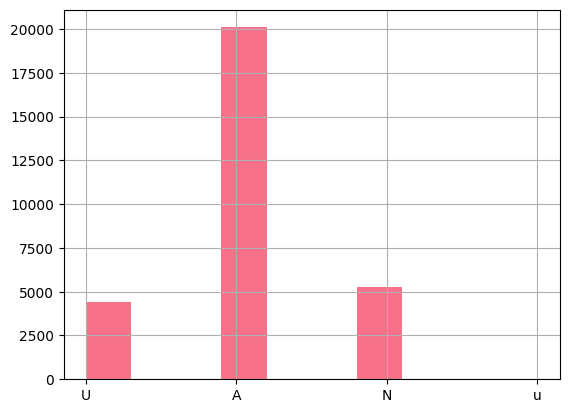

In [61]:
restroom_inspections = pd.merge(park_inspections_df, park_restroom_inspections_df, how="right",left_on="Inspection ID", right_on="InspectionID")

restroom_inspections['PR Overall Condition'].hist()
# U = Unacceptable
# A = Acceptable
# N = Not Inspected (?)

filtered_inspections = restroom_inspections[restroom_inspections['Inspection Year'] >= 2023] # Only look since 2023, capture recent results
pr_cols = ['PR Overall Condition', 'PR Litter', 'PR Graffiti', 'PR Amenities', 'PR Structural']
restroom_by_prop = filtered_inspections.groupby("Prop ID").agg({
    **{col: lambda x: ((x == 'U').sum() / ((x == 'U') | (x == 'A')).sum() * 100) if ((x == 'U') | (x == 'A')).sum() > 0 else 0
         for col in pr_cols},
      'InspectionID': 'nunique'}).round(2)
restroom_by_prop = restroom_by_prop.rename(columns={'InspectionID': 'Unique_Inspections'})
restroom_by_prop

In [62]:
bathrooms_per_prop_id = restroom_inspections.groupby('Prop ID')['PRNumber'].nunique()
bathrooms_per_prop_id = bathrooms_per_prop_id.reset_index().rename(columns={'PRNumber':'Cnt_Bathrooms'})
bathrooms_per_prop_id


,Prop ID,Cnt_Bathrooms
0,B001,1
1,B007,1
2,B007-01,1
3,B008,1
4,B008-03,1
...,...,...
950,X344-01,1
951,X353,1
952,XR-02,1
953,XR-03,1


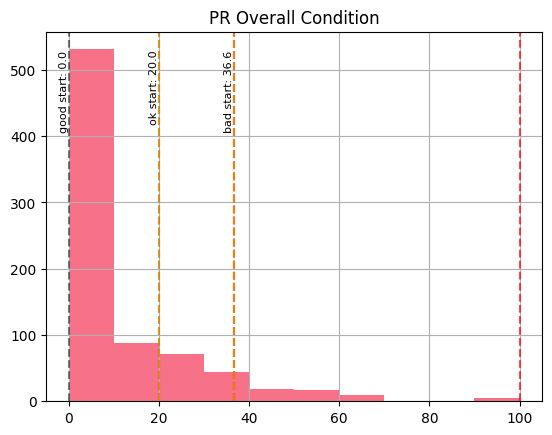

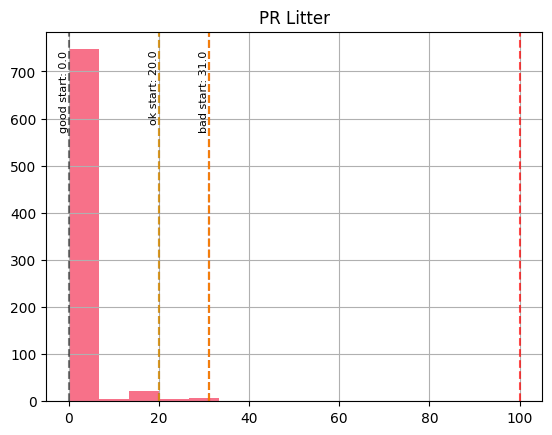

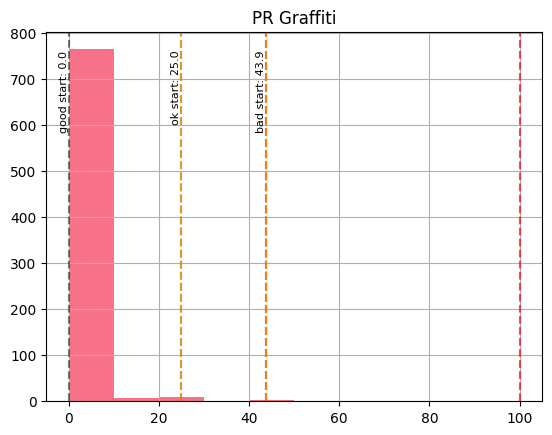

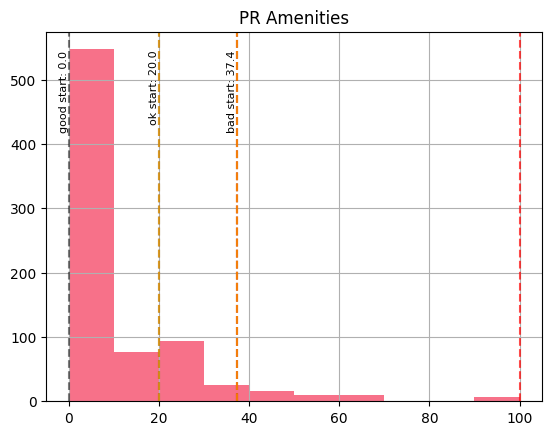

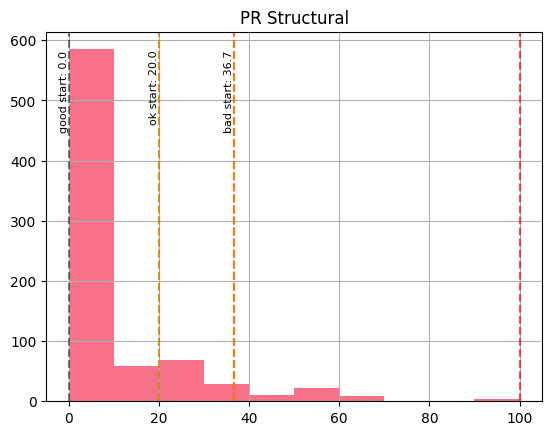

,PropNum,Prop ID,Boro,AMPSDistrict,Prop Name,Site Name,Prop Location,Site Location,Acres,Category,...,geometry,park_lat,park_lng,fips,bathroom_overall_condition,bathroom_litter,bathroom_graffiti,bathroom_amenities,bathroom_structural,Cnt_Bathrooms
0,B210W,B210W,B,10,John J Carty Park,John J Carty Park,Ft. Hamilton Pkwy. bet. 94 St. and 101 St.,Ft. Hamilton Pkwy. bet. 94 St. and 101 St.,8.565,Large Park,...,MULTIPOLYGON (((-74.0300932735937 40.612841501...,40.613272,-74.030159,36047016200,0,0,0,0,0,1.0
1,B210V,B210V,B,10,Park,Park,Dahlgreen Pl. bet. Exit 17 and Ft. Hill Pl.,Dahlgreen Pl. bet. Exit 17 and Ft. Hill Pl.,0.586,Other,...,MULTIPOLYGON (((-74.02665909407455 40.61473026...,40.614135,-74.027112,36047016400,-1,-1,-1,-1,-1,0.0
2,B210U,B210U,B,10,Park,Park,92 St. bet. Gowanus Exwy. and Ft. Hamilton Pkwy.,92 St. bet. Gowanus Exwy. and Ft. Hamilton Pkwy.,0.002,Other,...,MULTIPOLYGON (((-74.02691153290087 40.61648448...,40.616375,-74.027004,36047016200,-1,-1,-1,-1,-1,0.0
3,B210T,B210T,B,10,Park,Park,N/B Gowanus Exwy. bet. 85 St. and 86 St.,N/B Gowanus Exwy. bet. 85 St. and 86 St.,0.004,Other,...,MULTIPOLYGON (((-74.02263251784636 40.61963394...,40.619787,-74.022518,36047014000,-1,-1,-1,-1,-1,0.0
4,B210S,B210S,B,10,Park,Park,S/B Gowanus Exwy. bet. 85 St. and 86 St.,S/B Gowanus Exwy. bet. 85 St. and 86 St.,0.004,Other,...,MULTIPOLYGON (((-74.02328071427831 40.62040292...,40.620306,-74.023372,36047014200,-1,-1,-1,-1,-1,0.0


In [63]:
pr_columns = ['PR Overall Condition', 'PR Litter',
       'PR Graffiti', 'PR Amenities', 'PR Structural']

feature_columns = []
for column in pr_columns:
    restroom_by_prop[column].hist()
    median = restroom_by_prop[restroom_by_prop[column] > 0][column].median()
    std = restroom_by_prop[restroom_by_prop[column] > 0][column].std()
    
    boundaries = {
        "good": (0,median),
        "ok":(median, median+std),
        "bad":(median+std, 100)
    }
    for label, (start, end) in boundaries.items():
        plt.axvline(start, color='k', linestyle='--', alpha=0.5)
        plt.text(start, plt.ylim()[1]*0.95, f'{label} start: {start:.1f}', rotation=90, va='top', ha='right', fontsize=8)
    plt.axvline(boundaries['bad'][0], color='r', linestyle='--', alpha=0.7, label='bad threshold')
    plt.axvline(boundaries['ok'][0], color='orange', linestyle='--', alpha=0.7, label='ok threshold')
    plt.axvline(boundaries['ok'][1], color='orange', linestyle='--', alpha=0.7)
    plt.axvline(boundaries['bad'][1], color='r', linestyle='--', alpha=0.7)
    plt.title(column)
    plt.show()
    
    good_bathrooms = restroom_by_prop[restroom_by_prop[column] < boundaries['good'][1]].index
    ok_restrooms   = restroom_by_prop[restroom_by_prop[column].between(boundaries['ok'][0], boundaries['ok'][0], inclusive='left')].index
    bad_restrooms  = restroom_by_prop[restroom_by_prop[column] >= boundaries['bad'][0]].index

    label = 'bathroom_'+(column.replace("PR ","").replace(" ","_").lower())
    park_sites_df[label] = park_sites_df['Prop ID'].apply(lambda x:2 if x in bad_restrooms else 1 if x in ok_restrooms else 0 if x in good_bathrooms else -1)
    feature_columns.append(label)
    
park_sites_df_featurized = pd.merge(park_sites_df, bathrooms_per_prop_id, how='left', on='Prop ID').fillna({'Cnt_Bathrooms': 0})

park_sites_df_featurized.head()


    

<Axes: xlabel='Inspection Year'>

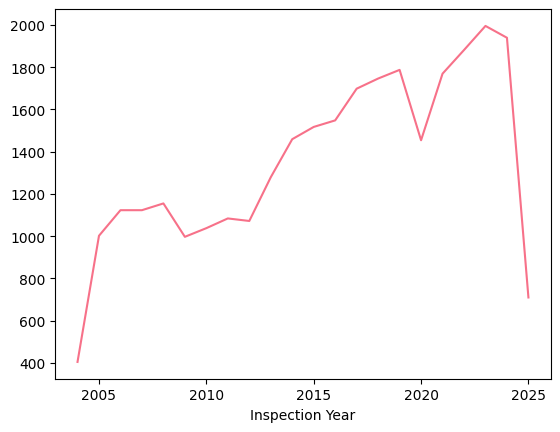

In [64]:
restroom_inspections.groupby('Inspection Year')['Prop ID'].count().plot()
# Expected drop in inspections in covid

        Prop ID  avg_inspections_per_year  years_recorded  total_inspections
455   Q001-ZN04                  4.000000               1                  4
46    B058-ZN01                  3.818182              11                 42
882   X126-ZN02                  3.625000               8                 29
306   M042-ZN01                  3.444444               9                 31
47    B058-ZN03                  3.400000              20                 68
363   M104-ZN01                  3.400000              15                 51
866        X104                  3.333333              12                 40
372   M107-ZN06                  3.250000              16                 52
724   R005-ZN01                  3.250000              20                 65
821   X030-ZN01                  3.214286              14                 45
483  Q010A-ZN02                  3.181818              11                 35
854   X092-ZN03                  3.105263              19                 59

Text(0.5, 1.0, 'Inspections per Year')

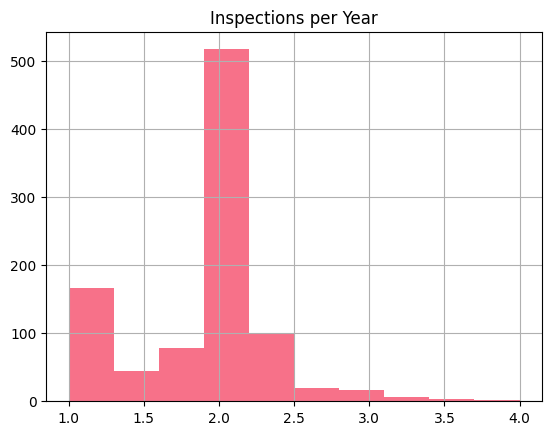

In [65]:
# count unique inspections per Prop ID per year, then compute the average per year
inspections_per_year = (
    restroom_inspections
    .groupby(['Prop ID', 'Inspection Year'])['InspectionID']
    .nunique()
    .reset_index(name='inspections_count')
)

avg_inspections_per_prop = (
    inspections_per_year
    .groupby('Prop ID')
    .agg(
        avg_inspections_per_year=('inspections_count', 'mean'),
        years_recorded=('Inspection Year', 'nunique'),
        total_inspections=('inspections_count', 'sum')
    )
    .reset_index()
)

# show results (sorted)
print(avg_inspections_per_prop.sort_values('avg_inspections_per_year', ascending=False).head(50))
plt1 = avg_inspections_per_prop["avg_inspections_per_year"].hist()
plt1.set_title("Inspections per Year")

In [66]:
def positive_mean(series):
    return series[series != -1].mean()

features = park_sites_df_featurized.groupby("fips").agg({
    **{col: positive_mean for col in feature_columns},
    'Cnt_Bathrooms':sum
})

print(features.describe())

save_location = Path('../data/derived/f_bathrooms.csv')
print(f"Saving to {save_location}")

features.reset_index().rename(columns={
    'fips':'tract_geoid', 
    'Cnt_Bathrooms':'bathroom_count'}).to_csv(save_location, index=False)



       bathroom_overall_condition  bathroom_litter  bathroom_graffiti  \
count                  469.000000       533.000000         540.000000   
mean                     0.186682         0.024182           0.003935   
std                      0.566195         0.213202           0.086224   
min                      0.000000         0.000000           0.000000   
25%                      0.000000         0.000000           0.000000   
50%                      0.000000         0.000000           0.000000   
75%                      0.000000         0.000000           0.000000   
max                      2.000000         2.000000           2.000000   

       bathroom_amenities  bathroom_structural  Cnt_Bathrooms  
count          468.000000           483.000000    1600.000000  
mean             0.117002             0.150966       0.617500  
std              0.433798             0.508800       1.431337  
min              0.000000             0.000000       0.000000  
25%              0.000

*Status*
Have initial features for number of bathrooms and bathroom quality for each FIPS.  Some further areas to explore to flush this out
* Is there any detectable bias based on the inspector?
* Are there any seasonal trends in the bathroom quality reports?
* Is there further signal in:
  * The more detailed PR types outside of overall cleanliness (e.g. litter, graffiti, etc.) - Done
  * The individual bathroom rooms data (e.g. men's room dirtier than the women's room) - Done
    * Is there any evidence that the spread between men's and women's cleanliness increases over time? - Done
* Join with median income data and population data and look at coorrelation


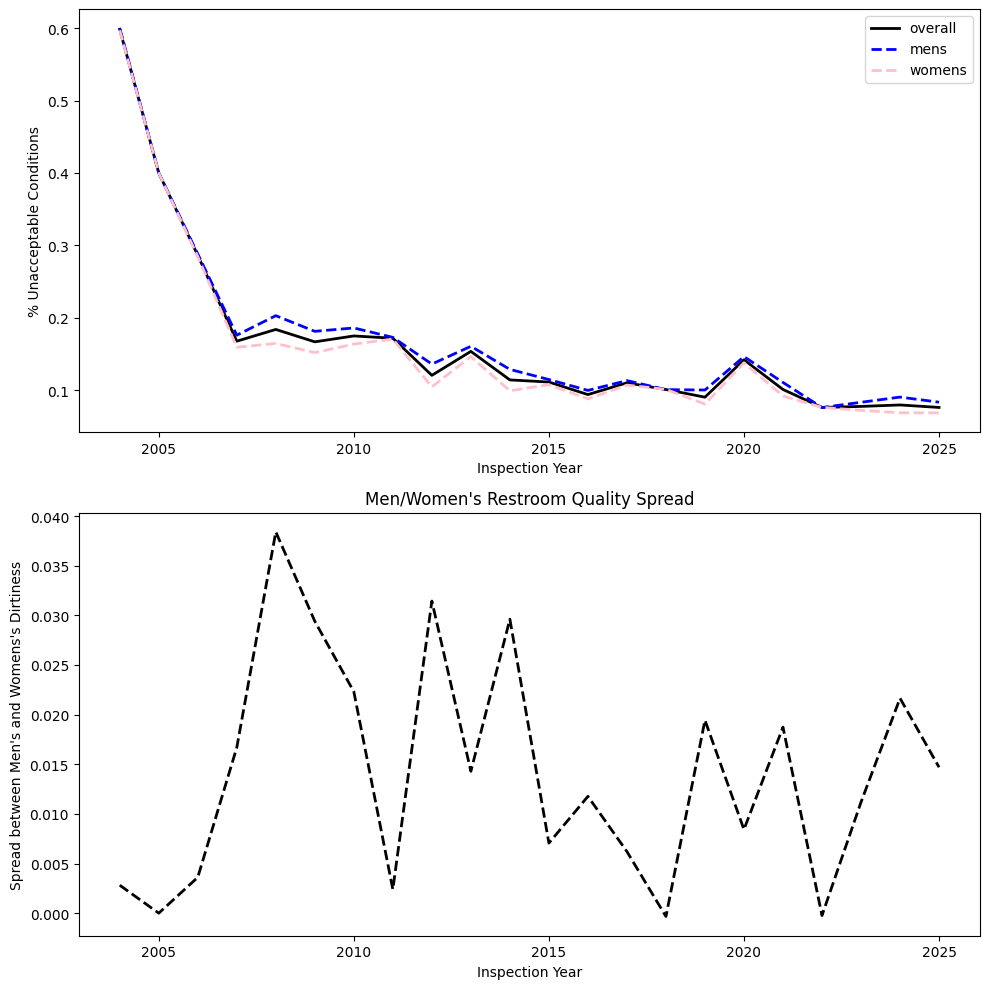

Men's unacceptable ratio:   15.03%
Women's unacceptable ratio: 13.59%


In [72]:
mens_rooms = park_restroom_rooms_inspections_df[park_restroom_rooms_inspections_df['MW'].str.startswith('M')]
womens_rooms = park_restroom_rooms_inspections_df[park_restroom_rooms_inspections_df['MW'].str.startswith('W')]

park_restroom_rooms_inspections_df['gender'] = park_restroom_rooms_inspections_df['MW'].apply(lambda x: 'mens' if x.startswith('M') else 'womens')
park_restroom_rooms_inspections_joined_df = pd.merge(park_restroom_rooms_inspections_df, 
                                                   park_inspections_df, 
                                                   left_on="InspectionID",
                                                   right_on="Inspection ID")

gender_counts_by_year = (
    park_restroom_rooms_inspections_joined_df
    .groupby(['Inspection Year', 'gender'])['OvCond']
    .apply(lambda x: (x == 'U').sum() / ((x == 'U') | (x == 'A')).sum() if ((x == 'U') | (x == 'A')).sum() > 0 else np.nan)
    .unstack(fill_value=0)
)
gender_counts_by_year['mens_womens_quality_spread'] = gender_counts_by_year.get('mens', 0) - gender_counts_by_year.get('womens', 0)

values_by_year = (
    park_restroom_rooms_inspections_joined_df
    .groupby(['Inspection Year'])['OvCond']
    .apply(lambda x: (x == 'U').sum() / ((x == 'U') | (x == 'A')).sum() if ((x == 'U') | (x == 'A')).sum() > 0 else np.nan)
)
data = (pd
        .merge(values_by_year.reset_index(),gender_counts_by_year[['mens','womens']].reset_index(), on='Inspection Year')
        .rename(columns={'OvCond':'overall'})
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
data.plot(x='Inspection Year', y=['overall', 'mens', 'womens'], ax=ax1, color=['black', 'blue', 'pink'], linewidth=2, style=['-', '--', '--'])
#data.plot(x='Inspection Year', y=['overall'], ax=ax1, color=['black'], linewidth=2, style=['-'])
ax1.set_ylabel("% Unacceptable Conditions")

# Plot men's and women's unacceptable ratios by year
gender_counts_by_year['mens_womens_quality_spread'].plot(ax=ax2, color='black', linewidth=2, style='--', label="Men's-Women's Spread")
ax2.set_ylabel("Spread between Men's and Womens's Dirtiness")
ax2.set_title("Men/Women's Restroom Quality Spread")
ax2.set_xlabel("Inspection Year")
plt.tight_layout()
plt.show()


mens_unacceptable_ratio = len(mens_rooms[mens_rooms["OvCond"] == "U"]) / (len(mens_rooms[mens_rooms["OvCond"] == "U"])+ len(mens_rooms[mens_rooms["OvCond"] == "A"]))
womens_unacceptable_ratio = len(womens_rooms[womens_rooms["OvCond"] == "U"]) / (len(womens_rooms[womens_rooms["OvCond"] == "U"])+ len(womens_rooms[womens_rooms["OvCond"] == "A"]))

print(f"Men's unacceptable ratio:   {round(mens_unacceptable_ratio*100, 2)}%")
print(f"Women's unacceptable ratio: {round(womens_unacceptable_ratio*100, 2)}%")

In [75]:
(park_restroom_hazards_df.groupby('Type').Type.count()/len(park_restroom_hazards_df) * 100).sort_values(ascending=False).head(50)

Type
Litter                                               16.534633
Dispensers Missing Soap                              16.047126
No Paper Towels / Hand Dryer                         10.163180
No Toilet Paper                                       7.336313
Marker                                                4.137044
Inadequate Lighting                                   3.124788
Toilets OOS                                           3.026610
Fixture Deterioration                                 2.908118
Wall Deterioration                                    2.623739
Soap Dispensers Missing                               1.713048
Ceiling Deterioration                                 1.682578
Spray Paint                                           1.604713
Urinals OOS                                           1.506534
Paint Uneven / Not Uniform                            1.421897
Damaged or missing safety strap on changing table     1.418512
Soap Globe Missing                                

In [69]:
feature_frame = pd.read_csv("../data/ext_data/data/parks_inspection_program_–_feature_ratings_20251020.csv")
restroom_litter_features = park_restroom_hazards_df[park_restroom_hazards_df['Type'] == 'Litter']['Feature #'].apply(lambda x: int(x.replace(",","")))
restroom_inspections_with_litter = feature_frame[feature_frame['Feature #'].isin(restroom_litter_features)]['Inspection ID']
